In [16]:
import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
import pickle
import shap
import matplotlib.pyplot as plt
import xgboost

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, log_loss
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from functools import partial

from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

from bo_parameters import *

In [2]:
lgbm_tuned = {
    "learning_rate" : 0.1281147437213422, 
    "max_depth" : 8, 
    "n_estimators" : 993
}
# lgbm_tuned += LIGHTGBM_PARAMS

xgb_tuned = {
    "learning_rate" : 0.11111908522416483, 
    "max_depth" : 7, 
    "n_estimators" : 343
}
# xgb_tuned += XGBOOST_PARAMS


tabnet_tuned = {
    "gamma" : 1.2917828325804677, 
    "lambda_sparse" : 0.0001, 
    "n_steps" : 3,
    "n_a" : 32,
    "momentum" : 0.98,
}

tabnet_tuned["n_d"] = tabnet_tuned["n_a"]

tabnet_paper = {
    "gamma" : 1.2, 
    "lambda_sparse" : 0.0001, 
    "n_steps" : 7,
    "n_a" : 32,
    "momentum" : 0.9,
    "optimizer_params" : dict(lr=1e-2)
}
tabnet_paper["n_d"] = tabnet_paper["n_a"]

xgb_paper = {
    "max_depth" : 6, 
}

lgbm_paper = {
    "num_leaves" : 64,
}

In [3]:
train = pd.read_csv("data/kdd/small/appetency/train.csv")
valid = pd.read_csv("data/kdd/small/appetency/val.csv")
test = pd.read_csv("data/kdd/small/appetency/test.csv")

In [4]:
categorical_idx = list(range(190, train.shape[1] - 1))

categorical_dims = [len(set(list(train.iloc[:, x].unique()) + list(valid.iloc[:, x].unique()) + list(test.iloc[:, x].unique()))) for x in categorical_idx]

In [5]:
for idx in range(0, len(categorical_dims)):
    if categorical_dims[idx] > 1:
        train.iloc[:, categorical_idx[idx]] = [int(x) for x in train.iloc[:, categorical_idx[idx]]]
        valid.iloc[:, categorical_idx[idx]] = [int(x) for x in valid.iloc[:, categorical_idx[idx]]]
        test.iloc[:, categorical_idx[idx]] = [int(x) for x in test.iloc[:, categorical_idx[idx]]]
    else:
        train.iloc[:, categorical_idx[idx]] = [0] * train.shape[0]
        valid.iloc[:, categorical_idx[idx]] = [0] * valid.shape[0]
        test.iloc[:, categorical_idx[idx]] = [0] * test.shape[0]

In [6]:
train = pd.concat([train, valid])

In [7]:
train_X = train.drop(["TARGET"], axis=1)
train_y = train["TARGET"]

test_X = test.drop(["TARGET"], axis=1)
test_y = test["TARGET"]

In [8]:
model_lgbm = LGBMClassifier(**{**lgbm_tuned, **LIGHTGBM_PARAMS})
model_lgbm.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

Using categorical_feature in Dataset.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(learning_rate=0.1281147437213422, max_depth=8, metric='auc',
               n_estimators=993, objective='binary', random_state=42)

In [9]:
model_lgbm_paper = LGBMClassifier(**{**lgbm_paper, **LIGHTGBM_PARAMS})
model_lgbm_paper.fit(train_X, train_y, verbose=1, categorical_feature=categorical_idx)

LGBMClassifier(metric='auc', num_leaves=64, objective='binary', random_state=42)

In [10]:
model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
model_xgb.fit(train_X, train_y, verbose=1)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:22:10] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:22:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.11111908522416483, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=343, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [11]:
model_xgb_paper = XGBClassifier(**{**xgb_paper, **XGBOOST_PARAMS})
model_xgb_paper.fit(train_X, train_y, verbose=1)

[15:23:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:23:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=True,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [12]:
TABNET_PARAMS["verbose"] = 1

In [13]:
model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet.fit(train_X.values, train_y.values, max_epochs=30, batch_size=8192, virtual_batch_size=256)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.45275 |  0:00:50s
epoch 1  | loss: 0.13552 |  0:01:37s
epoch 2  | loss: 0.1122  |  0:02:28s
epoch 3  | loss: 0.10866 |  0:03:19s
epoch 4  | loss: 0.10052 |  0:04:09s
epoch 5  | loss: 0.09495 |  0:04:56s
epoch 6  | loss: 0.09335 |  0:05:44s
epoch 7  | loss: 0.09339 |  0:06:34s
epoch 8  | loss: 0.09204 |  0:07:22s
epoch 9  | loss: 0.0903  |  0:08:08s
epoch 10 | loss: 0.0881  |  0:08:58s
epoch 11 | loss: 0.08688 |  0:09:47s
epoch 12 | loss: 0.08651 |  0:10:35s
epoch 13 | loss: 0.08591 |  0:11:24s
epoch 14 | loss: 0.08503 |  0:12:12s
epoch 15 | loss: 0.08523 |  0:13:02s
epoch 16 | loss: 0.08472 |  0:13:51s
epoch 17 | loss: 0.08403 |  0:14:36s
epoch 18 | loss: 0.08367 |  0:15:26s
epoch 19 | loss: 0.08308 |  0:16:15s
epoch 20 | loss: 0.08277 |  0:17:02s
epoch 21 | loss: 0.08247 |  0:17:48s
epoch 22 | loss: 0.08275 |  0:18:36s
epoch 23 | loss: 0.08168 |  0:19:25s
epoch 24 | loss: 0.08

In [14]:
model_tabnet_paper = TabNetClassifier(**{**tabnet_paper, **TABNET_PARAMS}, cat_idxs=categorical_idx, cat_dims=categorical_dims)
model_tabnet_paper.fit(train_X.values, train_y.values, max_epochs=45, batch_size=8192, virtual_batch_size=256)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.68364 |  0:01:05s
epoch 1  | loss: 0.15025 |  0:02:10s
epoch 2  | loss: 0.14513 |  0:03:12s
epoch 3  | loss: 0.13577 |  0:04:17s
epoch 4  | loss: 0.13261 |  0:05:19s
epoch 5  | loss: 0.12932 |  0:06:19s
epoch 6  | loss: 0.11857 |  0:07:25s
epoch 7  | loss: 0.11329 |  0:08:30s
epoch 8  | loss: 0.11013 |  0:09:31s
epoch 9  | loss: 0.10445 |  0:10:35s
epoch 10 | loss: 0.10074 |  0:11:38s
epoch 11 | loss: 0.10024 |  0:12:41s
epoch 12 | loss: 0.09873 |  0:13:43s
epoch 13 | loss: 0.09217 |  0:14:48s
epoch 14 | loss: 0.09167 |  0:15:52s
epoch 15 | loss: 0.09026 |  0:16:58s
epoch 16 | loss: 0.08836 |  0:18:04s
epoch 17 | loss: 0.08998 |  0:19:08s
epoch 18 | loss: 0.08803 |  0:20:14s
epoch 19 | loss: 0.08802 |  0:21:20s
epoch 20 | loss: 0.08541 |  0:22:23s
epoch 21 | loss: 0.08599 |  0:23:28s
epoch 22 | loss: 0.08623 |  0:24:33s
epoch 23 | loss: 0.08545 |  0:25:37s
epoch 24 | loss: 0.08

In [175]:
with open('model_tabnet_kdd_appetency.pickle', 'wb') as f:
    pickle.dump(model_tabnet, f)
with open('model_tabnet_paper_kdd_appetency.pickle', 'wb') as f:
    pickle.dump(model_tabnet_paper, f)

In [10]:
with open('model_tabnet.pickle', 'rb') as f:
    model_tabnet = pickle.load(f)
with open('model_tabnet_paper.pickle', 'rb') as f:
    model_tabnet_paper = pickle.load(f)

In [64]:
print("LightGBM auc: ", round(roc_auc_score(test_y, model_lgbm.predict_proba(test_X)[:, 1]), 6))
print("LightGBM Paper auc: ", round(roc_auc_score(test_y, model_lgbm_paper.predict_proba(test_X)[:, 1]), 6))
print("XGBoost auc: ", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X)[:, 1]), 6))
print("XGBoost Paper auc: ", round(roc_auc_score(test_y, model_xgb_paper.predict_proba(test_X)[:, 1]), 6))
print("TabNet auc: ", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X.values)[:, 1]), 6))
print("TabNet Paper auc: ", round(roc_auc_score(test_y, model_tabnet_paper.predict_proba(test_X.values)[:, 1]), 6))

LightGBM auc:  0.75436
LightGBM Paper auc:  0.763391
XGBoost auc:  0.764413
XGBoost Paper auc:  0.767356
TabNet auc:  0.772021
TabNet Paper auc:  0.712255


In [65]:
print("LightGBM acc: ", round(accuracy_score(test_y, model_lgbm.predict(test_X)), 6))
print("LightGBM Paper acc: ", round(accuracy_score(test_y, model_lgbm_paper.predict(test_X)), 6))
print("XGBoost acc: ", round(accuracy_score(test_y, model_xgb.predict(test_X)), 6))
print("XGBoost Paper acc: ", round(accuracy_score(test_y, model_xgb_paper.predict(test_X)), 6))
print("TabNet acc: ", round(accuracy_score(test_y, model_tabnet.predict(test_X.values)), 6))
print("TabNet Paper acc: ", round(accuracy_score(test_y, model_tabnet_paper.predict(test_X.values)), 6))

LightGBM acc:  0.982002
LightGBM Paper acc:  0.981469
XGBoost acc:  0.981869
XGBoost Paper acc:  0.981869
TabNet acc:  0.980269
TabNet Paper acc:  0.982002


In [17]:
print("LightGBM log_loss: ", round(log_loss(test_y, model_lgbm.predict_proba(test_X)), 6))
print("LightGBM Paper log_loss: ", round(log_loss(test_y, model_lgbm_paper.predict_proba(test_X)), 6))
print("XGBoost log_loss: ", round(log_loss(test_y, model_xgb.predict_proba(test_X)), 6))
print("XGBoost Paper log_loss: ", round(log_loss(test_y, model_xgb_paper.predict_proba(test_X)), 6))
print("TabNet log_loss: ", round(log_loss(test_y, model_tabnet.predict_proba(test_X.values)), 6))
print("TabNet Paper log_loss: ", round(log_loss(test_y, model_tabnet_paper.predict_proba(test_X.values)), 6))

LightGBM log_loss:  0.229265
LightGBM Paper log_loss:  0.126765
XGBoost log_loss:  0.095654
XGBoost Paper log_loss:  0.088594
TabNet log_loss:  0.088978
TabNet Paper log_loss:  0.086604


In [18]:
importance_lgbm = list(enumerate(model_lgbm.feature_importances_))
importance_lgbm_paper = list(enumerate(model_lgbm_paper.feature_importances_))
importance_xgb = model_xgb.get_booster().get_score(importance_type='weight').items()
importance_xgb_paper = model_xgb_paper.get_booster().get_score(importance_type='weight').items()
importance_tabnet = list(enumerate(model_tabnet.feature_importances_))
importance_tabnet_paper = list(enumerate(model_tabnet_paper.feature_importances_))

In [19]:
importance_lgbm = sorted(importance_lgbm, key=lambda x: x[1], reverse=True)
importance_lgbm = sorted(importance_lgbm_paper, key=lambda x: x[1], reverse=True)
importance_xgb = sorted(importance_xgb, key=lambda x: x[1], reverse=True)
importance_xgb_paper = sorted(importance_xgb_paper, key=lambda x: x[1], reverse=True)
importance_tabnet = sorted(importance_tabnet, key=lambda x: x[1], reverse=True)
importance_tabnet_paper = sorted(importance_tabnet_paper, key=lambda x: x[1], reverse=True)

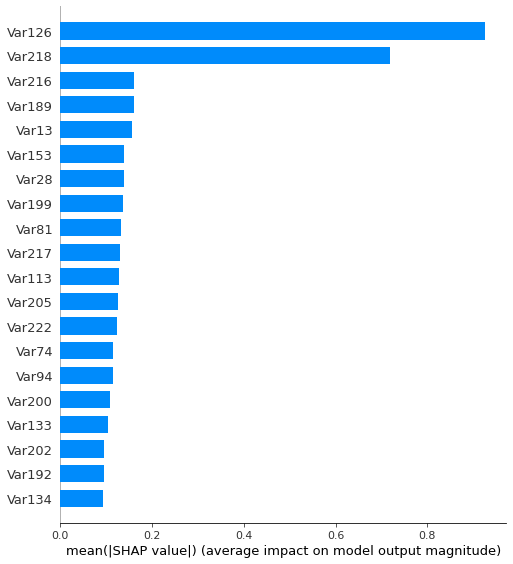

In [20]:
shap_values = shap.TreeExplainer(model_xgb).shap_values(train_X)
shap.summary_plot(shap_values, train_X, plot_type="bar")

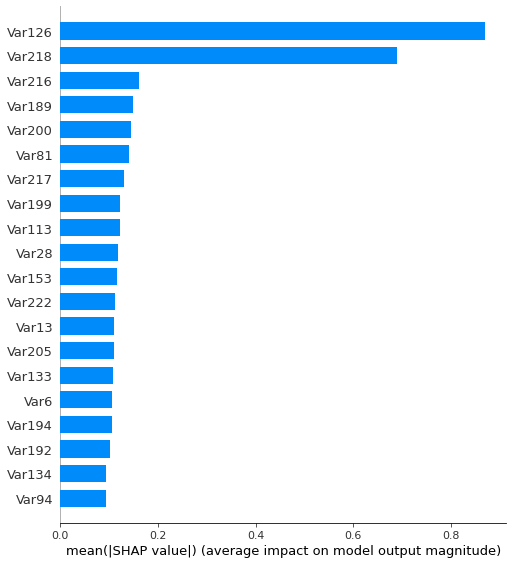

In [21]:
shap_values_paper = shap.TreeExplainer(model_xgb_paper).shap_values(train_X)
shap.summary_plot(shap_values_paper, train_X, plot_type="bar")

In [22]:
df_compare = pd.DataFrame([train_X.columns[x[0]] for x in importance_lgbm], columns=["LightGBM"])
df_compare["LightGBM_Paper"] = [train_X.columns[x[0]] for x in importance_lgbm]
df_compare["XGBoost"] = [x[0] for x in importance_xgb] + list(set(train_X.columns[:-1]) - set([x[0] for x in importance_xgb])) + [train_X.columns[-1]]
df_compare["XGBoost_Paper"] = [x[0] for x in importance_xgb_paper] + list(set(train_X.columns[:-1]) - set([x[0] for x in importance_xgb_paper])) + [train_X.columns[-1]]
df_compare["SHAP_XGBoost"] = train_X.columns[np.argsort(np.abs(shap_values).mean(0))][::-1]
df_compare["SHAP_XGBoost_Paper"] = train_X.columns[np.argsort(np.abs(shap_values_paper).mean(0))][::-1]
df_compare["TabNet"] = [train_X.columns[x[0]] for x in importance_tabnet]
df_compare["TabNet_Paper"] = [train_X.columns[x[0]] for x in importance_tabnet_paper]

In [24]:
df_compare.head(10)

,LightGBM,LightGBM_Paper,XGBoost,XGBoost_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper
0,Var126,Var126,Var113,Var217,Var126,Var126,Var218,Var126
1,Var113,Var113,Var199,Var199,Var218,Var218,Var21_imputed,Var88_imputed
2,Var202,Var202,Var202,Var222,Var216,Var216,Var190,Var59_imputed
3,Var198,Var198,Var222,Var192,Var189,Var189,Var126_imputed,Var156
4,Var199,Var199,Var217,Var202,Var13,Var200,Var187_imputed,Var164_imputed
5,Var94,Var94,Var192,Var198,Var153,Var81,Var216,Var201
6,Var28,Var28,Var220,Var113,Var28,Var217,Var34,Var229
7,Var73,Var73,Var198,Var126,Var199,Var199,Var178_imputed,Var130_imputed
8,Var81,Var81,Var204,Var81,Var81,Var113,Var112,Var147_imputed
9,Var192,Var192,Var216,Var220,Var217,Var28,Var111,Var84


In [25]:
top3_feats = {}
top3_feats["xgboost"] = ["Var113", "Var199", "Var202"]
top3_feats["shap"] = ["Var126", "Var218", "Var216"]
top3_feats["tabnet"] = ["Var218", "Var21_imputed", "Var190"]

In [26]:
top10_feats = {}
top10_feats["xgboost"] = ["Var113", "Var199", "Var202", "Var222", "Var217", "Var192", "Var220", "Var198", "Var204", "Var216"]
top10_feats["shap"] = ["Var126", "Var218", "Var216", "Var189", "Var13", "Var153", "Var28", "Var199", "Var81", "Var217"]
top10_feats["tabnet"] = ["Var218", "Var21_imputed", "Var190", "Var126_imputed", "Var187_imputed", "Var216", "Var34", "Var178_imputed", "Var112", "Var111"]

In [90]:
top_3 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:2, col1]) & set(df_compare.loc[:2, col2])))
        top_3.append(d)
top_3_data = pd.DataFrame(top_3, columns=["Model1", "Model2", "Sim"])
    

In [91]:
pd.pivot_table(top_3_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,,
LightGBM,3,3,1,1,0,1,2,0
LightGBM_Paper,3,3,1,1,0,1,2,0
SHAP_XGBoost,1,1,3,3,1,1,0,0
SHAP_XGBoost_Paper,1,1,3,3,1,1,0,0
TabNet,0,0,1,1,3,0,0,0
TabNet_Paper,1,1,1,1,0,3,0,0
XGBoost,2,2,0,0,0,0,3,1
XGBoost_Paper,0,0,0,0,0,0,1,3


In [92]:
top_5 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:4, col1]) & set(df_compare.loc[:4, col2])))
        top_5.append(d)
top_5_data = pd.DataFrame(top_5, columns=["Model1", "Model2", "Sim"])
    

pd.pivot_table(top_5_data, values='Sim', index=['Model1'], columns=['Model2'])

In [94]:
top_10 = []

for i in range(len(df_compare.columns)):
    for j in range(len(df_compare.columns)):
        col1 = df_compare.columns[i]
        col2 = df_compare.columns[j]
        d = []
        d.append(col1)
        d.append(col2)
        d.append(len(set(df_compare.loc[:9, col1]) & set(df_compare.loc[:9, col2])))
        top_10.append(d)
top_10_data = pd.DataFrame(top_10, columns=["Model1", "Model2", "Sim"])
    

In [95]:
pd.pivot_table(top_10_data, values='Sim', index=['Model1'], columns=['Model2'])

Model2,LightGBM,LightGBM_Paper,SHAP_XGBoost,SHAP_XGBoost_Paper,TabNet,TabNet_Paper,XGBoost,XGBoost_Paper
Model1,,,,,,,,
LightGBM,10,10,4,5,0,1,5,7
LightGBM_Paper,10,10,4,5,0,1,5,7
SHAP_XGBoost,4,4,10,8,2,1,3,4
SHAP_XGBoost_Paper,5,5,8,10,2,1,4,5
TabNet,0,0,2,2,10,0,1,0
TabNet_Paper,1,1,1,1,0,10,0,1
XGBoost,5,5,3,4,1,0,10,8
XGBoost_Paper,7,7,4,5,0,1,8,10


In [29]:
top3_results = []
for model, feats in top3_feats.items():
    train_X_slice = train_X[feats]
    test_X_slice = test_X[feats]
    cat_feats = set(train_X_slice.columns) & set([train_X.columns[x] for x in categorical_idx])
    cat_idx = sorted([list(train_X_slice.columns).index(x) for x in cat_feats])
    cat_dims = [len(set(list(train_X_slice.iloc[:, x].unique()) + list(test_X_slice.iloc[:, x].unique()))) for x in cat_idx]
    
    model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
    model_xgb.fit(train_X_slice, train_y, verbose=1)
    top3_results.append([model, "XGBoost", "acc", round(accuracy_score(test_y, model_xgb.predict(test_X_slice)), 6)])
    top3_results.append([model, "XGBoost", "auc", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X_slice)[:, 1]), 6)])
    result = []
    model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=cat_idx, cat_dims=cat_dims)
    model_tabnet.fit(train_X_slice.values, train_y.values, max_epochs=30)
    top3_results.append([model, "TabNet", "acc", round(accuracy_score(test_y, model_tabnet.predict(test_X_slice.values)), 6)])
    top3_results.append([model, "TabNet", "auc", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X_slice.values)[:, 1]), 6)])
    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:51:13] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:51:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.13339 |  0:00:05s
epoch 1  | loss: 0.09092 |  0:00:11s
epoch 2  | loss: 0.09012 |  0:00:17s
epoch 3  | loss: 0.0895  |  0:00:23s
epoch 4  | loss: 0.08739 |  0:00:29s
epoch 5  | loss: 0.08385 |  0:00:34s
epoch 6  | loss: 0.08206 |  0:00:40s
epoch 7  | loss: 0.07749 |  0:00:46s
epoch 8  | loss: 0.07403 |  0:00:52

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:54:18] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:54:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.10293 |  0:00:05s
epoch 1  | loss: 0.07967 |  0:00:11s
epoch 2  | loss: 0.07885 |  0:00:17s
epoch 3  | loss: 0.07963 |  0:00:23s
epoch 4  | loss: 0.07755 |  0:00:29s
epoch 5  | loss: 0.07747 |  0:00:34s
epoch 6  | loss: 0.07681 |  0:00:40s
epoch 7  | loss: 0.07728 |  0:00:47s
epoch 8  | loss: 0.07561 |  0:00:54

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:57:20] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:57:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.14081 |  0:00:05s
epoch 1  | loss: 0.08728 |  0:00:11s
epoch 2  | loss: 0.08782 |  0:00:17s
epoch 3  | loss: 0.08629 |  0:00:23s
epoch 4  | loss: 0.0858  |  0:00:29s
epoch 5  | loss: 0.08577 |  0:00:35s
epoch 6  | loss: 0.08485 |  0:00:41s
epoch 7  | loss: 0.08522 |  0:00:47s
epoch 8  | loss: 0.08518 |  0:00:52

In [30]:
top_3_scores = pd.DataFrame(top3_results, columns=["Features", "Model", "Score", "Value"])

In [31]:
pd.pivot_table(top_3_scores, values='Value', index=['Features'], columns=['Model', "Score"])

Model       TabNet             XGBoost          
Score          acc       auc       acc       auc
Features                                        
shap      0.982002  0.758138  0.982002  0.775170
tabnet    0.982002  0.684538  0.982002  0.685575
xgboost   0.982002  0.649726  0.981869  0.586327

In [32]:
top10_results = []
for model, feats in top10_feats.items():
    train_X_slice = train_X[feats]
    test_X_slice = test_X[feats]
    cat_feats = set(train_X_slice.columns) & set([train_X.columns[x] for x in categorical_idx])
    cat_idx = sorted([list(train_X_slice.columns).index(x) for x in cat_feats])
    cat_dims = [len(set(list(train_X_slice.iloc[:, x].unique()) + list(test_X_slice.iloc[:, x].unique()))) for x in cat_idx]
    
    model_xgb = XGBClassifier(**{**xgb_tuned, **XGBOOST_PARAMS})
    model_xgb.fit(train_X_slice, train_y, verbose=1)
    top10_results.append([model, "XGBoost", "acc", round(accuracy_score(test_y, model_xgb.predict(test_X_slice)), 6)])
    top10_results.append([model, "XGBoost", "auc", round(roc_auc_score(test_y, model_xgb.predict_proba(test_X_slice)[:, 1]), 6)])
    result = []
    model_tabnet = TabNetClassifier(**{**tabnet_tuned, **TABNET_PARAMS}, cat_idxs=cat_idx, cat_dims=cat_dims)
    model_tabnet.fit(train_X_slice.values, train_y.values, max_epochs=30)
    top10_results.append([model, "TabNet", "acc", round(accuracy_score(test_y, model_tabnet.predict(test_X_slice.values)), 6)])
    top10_results.append([model, "TabNet", "auc", round(roc_auc_score(test_y, model_tabnet.predict_proba(test_X_slice.values)[:, 1]), 6)])
    

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:03:12] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:03:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.16808 |  0:00:11s
epoch 1  | loss: 0.09161 |  0:00:25s
epoch 2  | loss: 0.08997 |  0:00:38s
epoch 3  | loss: 0.08913 |  0:00:50s
epoch 4  | loss: 0.08933 |  0:01:02s
epoch 5  | loss: 0.08839 |  0:01:15s
epoch 6  | loss: 0.0867  |  0:01:28s
epoch 7  | loss: 0.08603 |  0:01:41s
epoch 8  | loss: 0.08523 |  0:01:54

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:09:51] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:09:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.12541 |  0:00:11s
epoch 1  | loss: 0.08223 |  0:00:22s
epoch 2  | loss: 0.08004 |  0:00:33s
epoch 3  | loss: 0.07834 |  0:00:45s
epoch 4  | loss: 0.07807 |  0:00:57s
epoch 5  | loss: 0.07736 |  0:01:12s
epoch 6  | loss: 0.07738 |  0:01:25s
epoch 7  | loss: 0.07704 |  0:01:38s
epoch 8  | loss: 0.07603 |  0:01:51

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:16:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:16:25] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.13801 |  0:00:12s
epoch 1  | loss: 0.08897 |  0:00:23s
epoch 2  | loss: 0.08666 |  0:00:36s
epoch 3  | loss: 0.0866  |  0:00:48s
epoch 4  | loss: 0.08604 |  0:01:00s
epoch 5  | loss: 0.08432 |  0:01:13s
epoch 6  | loss: 0.08412 |  0:01:26s
epoch 7  | loss: 0.08473 |  0:01:38s
epoch 8  | loss: 0.08559 |  0:01:51

In [33]:
top_10_scores = pd.DataFrame(top10_results, columns=["Features", "Model", "Score", "Value"])

In [34]:
pd.pivot_table(top_10_scores, values='Value', index=['Features'], columns=['Model', "Score"])

Model       TabNet             XGBoost          
Score          acc       auc       acc       auc
Features                                        
shap      0.975603  0.744122  0.981736  0.758761
tabnet    0.982002  0.636967  0.982002  0.709242
xgboost   0.978403  0.600809  0.982002  0.613696